# Interpretation of the difference between classical and separable convolution

In [9]:
# from utils import *
import pandas as pd
from torch.utils.data import random_split
import librosa
from utils import DCaseDataset
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

In [4]:
# Define Classical 5x5 ConvBlock
class ConvBlock5x5(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock5x5, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(5, 5), stride=(1, 1),
                              padding=(2, 2), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        

    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.avg_pool2d(x, kernel_size=pool_size)
        
        return x

In [5]:
class Conv(nn.Module):
    def __init__(self, cout):
        """

        :param cout:
        """
        super(Conv, self).__init__()
        self.bn = nn.BatchNorm2d(cout, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AvgPool2d(2)

    def conv(self, x):
        """

        :param x:
        :return:
        """
        raise NotImplementedError()

    def merge_conv_bn(self):
        """

        :return:
        """
        raise NotImplementedError()

    def forward(self, x):
        """

        :param x:
        :return:
        """
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x


class SepConv(Conv):
    def __init__(self, cin, cout):
        """

        :param cin:
        :param cout:
        """
        super(SepConv, self).__init__(cout)

        # --- 1 x 1 conv
        self.ch_conv1 = nn.Conv2d(
            cin,
            cout,
            kernel_size=1,
            stride=1,
            padding=0,
            dilation=1,
            groups=1,
            bias=False,
            padding_mode="zeros",
        )

        # --- Spatial convolution channel-wise convolution
        # 1 x 3 with dilation 2
        self.sp_conv1 = nn.Conv2d(
            cout,
            cout,
            kernel_size=(3, 1),
            stride=1,
            padding=(2, 0),
            dilation=(2, 1),
            groups=cout,
            bias=False,
            padding_mode="zeros",
        )
        # 3 x 1 with dilation 2
        self.sp_conv2 = nn.Conv2d(
            cout,
            cout,
            kernel_size=(1, 3),
            stride=1,
            padding=(0, 2),
            dilation=(1, 2),
            groups=cout,
            bias=False,
            padding_mode="zeros",
        )
        
    def merge_conv_bn(self):
        """

        :return:
        """
        # Compute scale and shift from batch norm parameters
        scale = self.bn.weight / torch.sqrt(self.bn.running_var)
        bias = self.bn.bias - scale * self.bn.running_mean
        # Update convolution layers
        self.sp_conv1.weight.data = (
            self.sp_conv1.weight.data * scale[:, None, None, None].data
        )
        self.sp_conv2.weight.data = (
            self.sp_conv2.weight.data * scale[:, None, None, None].data
        )
        self.sp_conv2.bias = nn.Parameter(bias.detach())
        # Remove batch norm
        self.bn = nn.Identity()

    def conv(self, x):
        """

        :param x:
        :return:
        """
        x = self.ch_conv1(x)
        x = self.sp_conv1(x) + self.sp_conv2(x)
        return x

In [8]:
# Loading MNIST dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
MNIST_dataset =     datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))



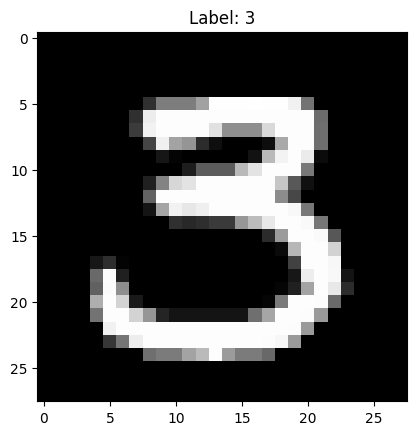

In [25]:
data_loader = DataLoader(MNIST_dataset, batch_size=1, shuffle=True)
for images, labels in data_loader:
    # Display the image using matplotlib
    image = images[0].squeeze().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {labels.item()}")
    plt.show()

    # Convert the image tensor to a PyTorch variable if needed
    image_tensor = torch.tensor(image)
    break

In [26]:
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)

In [27]:
ClassicConv = ConvBlock5x5(1, 1)
SeparableConv = SepConv(1, 1)

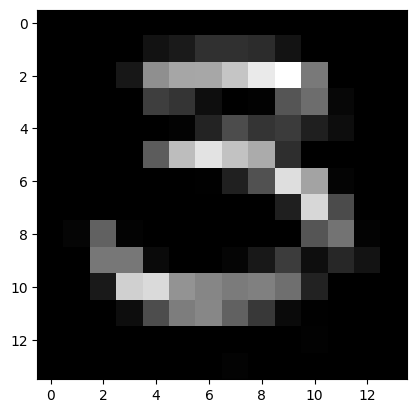

In [31]:
classic_out = ClassicConv(image_tensor)
image_out = classic_out.squeeze(0).squeeze(0).detach().numpy()
plt.imshow(image_out, cmap='gray')
plt.show()

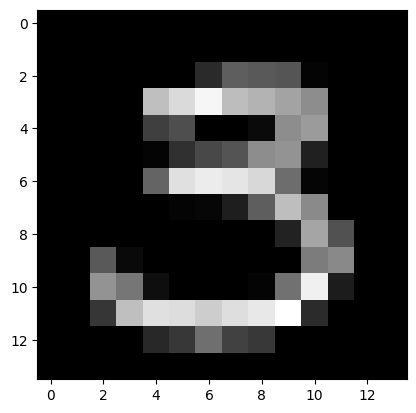

In [32]:
sep_out = SeparableConv(image_tensor)
image_out = sep_out.squeeze(0).squeeze(0).detach().numpy()
plt.imshow(image_out, cmap='gray')
plt.show()

In [51]:
ClassicConv = ConvBlock5x5(3, 3)
SeparableConv = SepConv(3, 3)

In [52]:
# Loading Stanford cars dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
CIFAR_dataset =     datasets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))

Files already downloaded and verified


torch.Size([3, 32, 32])


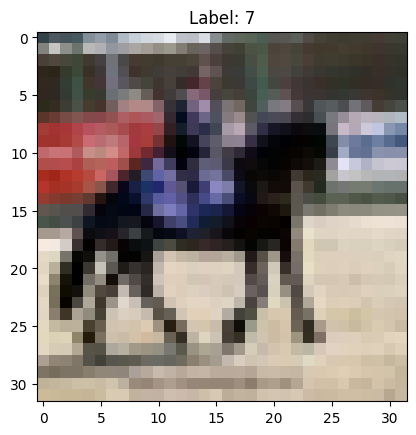

In [56]:
# Load the image and its label using the index
image, label = CIFAR_dataset[5000]
print(image.shape)
# Display the image using matplotlib
plt.imshow(image.permute(1, 2, 0))  # Permute the dimensions for matplotlib
plt.title(f"Label: {label}")
plt.show()

In [57]:
image = image.unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 16, 16])


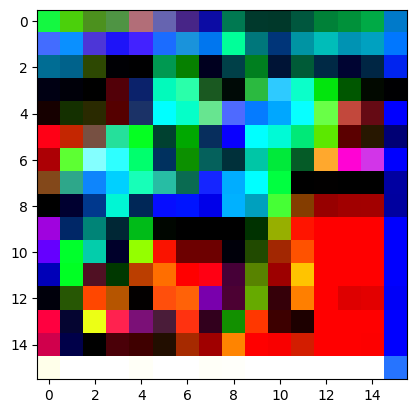

In [59]:
classic_out = ClassicConv(image)
print(classic_out.shape)
image_out = classic_out.squeeze(0).detach().numpy()
plt.imshow(image_out.transpose(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 16, 16])


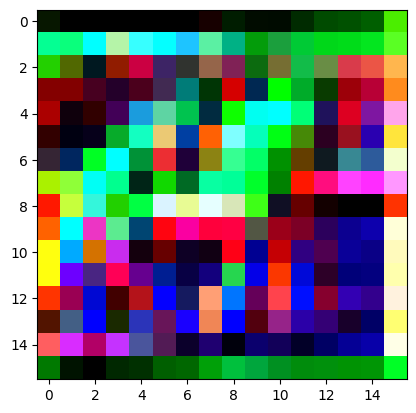

In [60]:
sep_out = SeparableConv(image)
print(sep_out.shape)
image_out = sep_out.squeeze(0).detach().numpy()
plt.imshow(image_out.transpose(1, 2, 0))
plt.show()

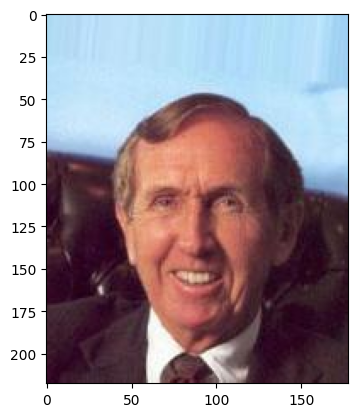

In [80]:
from PIL import Image
to_tensor = transforms.ToTensor()

# Apply the transformation to convert the image to a PyTorch tensor

image = Image.open("./data/custom/000021.jpg").convert("RGB")
tensor_image = to_tensor(image)
plt.imshow(image)
plt.show()

tensor_image = tensor_image.unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 109, 89])


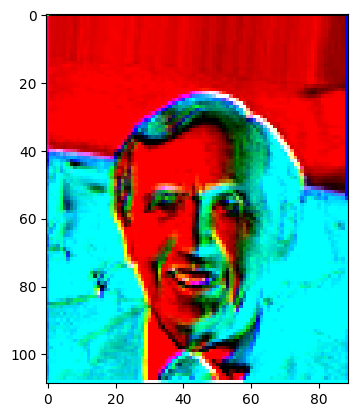

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 54, 44])


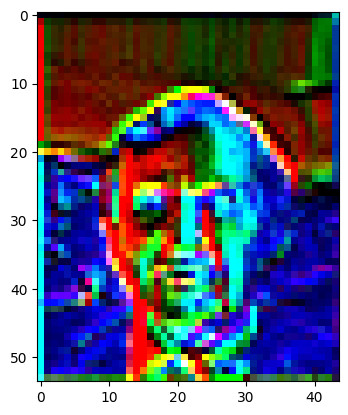

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 27, 22])


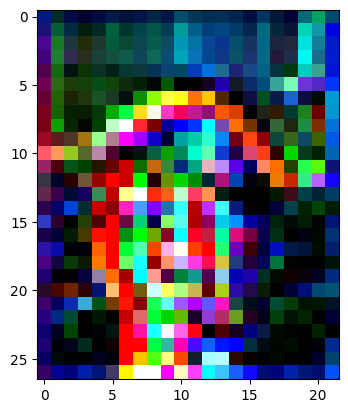

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 13, 11])


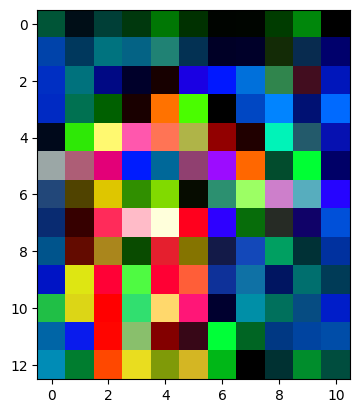

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 6, 5])


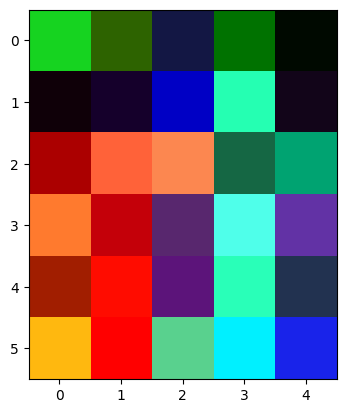

In [77]:
for i in range(5):
    classic_out = ClassicConv(tensor_image)
    print(classic_out.shape)
    image_out = classic_out.squeeze(0).detach().numpy()
    plt.imshow(image_out.transpose(1, 2, 0))
    plt.show()

    tensor_image = classic_out

In [78]:
to_tensor = transforms.ToTensor()

# Apply the transformation to convert the image to a PyTorch tensor

image = Image.open("./data/custom/000021.jpg").convert("RGB")
tensor_image = to_tensor(image)

tensor_image = tensor_image.unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 109, 89])


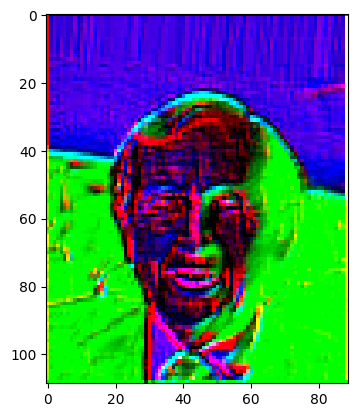

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 54, 44])


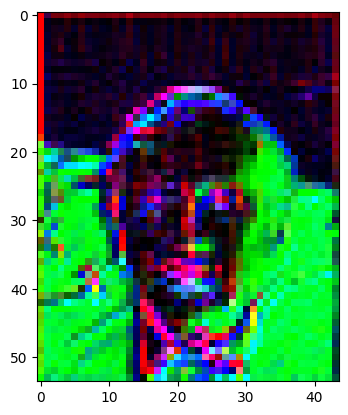

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 27, 22])


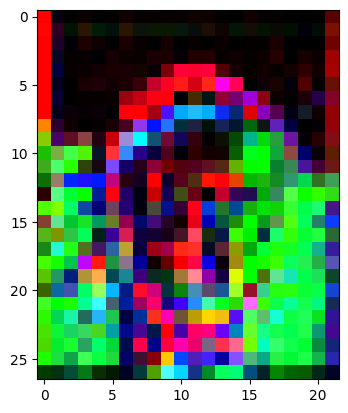

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 13, 11])


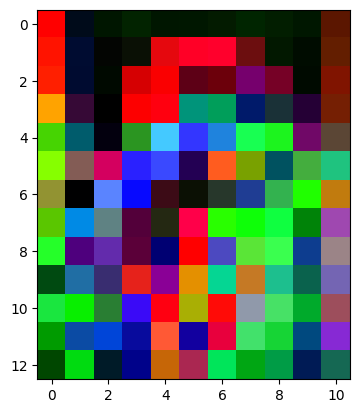

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 6, 5])


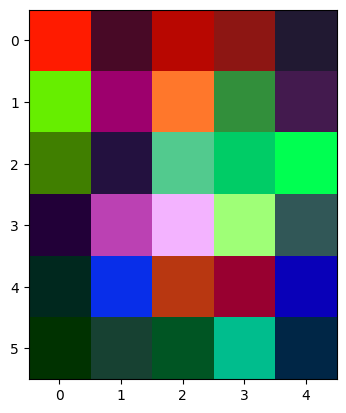

In [79]:
for i in range(5):
    sep_out = SeparableConv(tensor_image)
    print(sep_out.shape)
    image_out = sep_out.squeeze(0).detach().numpy()
    plt.imshow(image_out.transpose(1, 2, 0))
    plt.show()

    tensor_image = sep_out

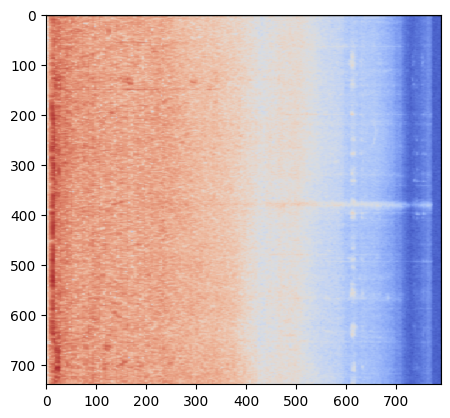

In [81]:
image = Image.open("./data/custom/spectrogram.png").convert("RGB")
tensor_image = to_tensor(image)
plt.imshow(image)
plt.show()

tensor_image = tensor_image.unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 370, 395])


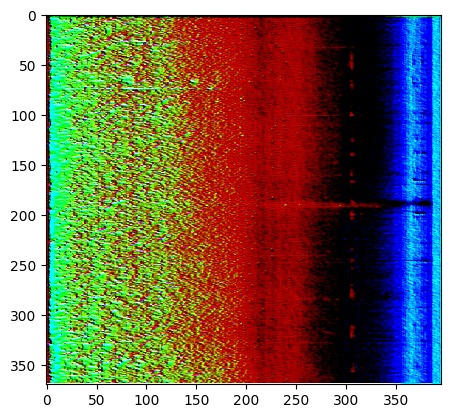

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 185, 197])


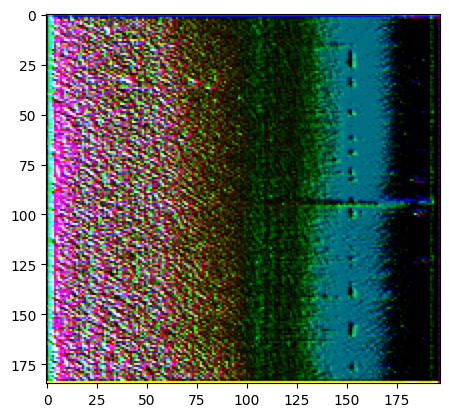

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 92, 98])


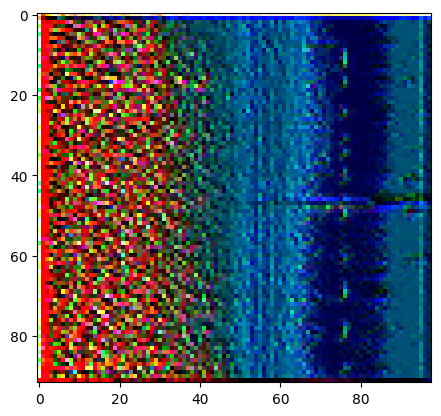

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 46, 49])


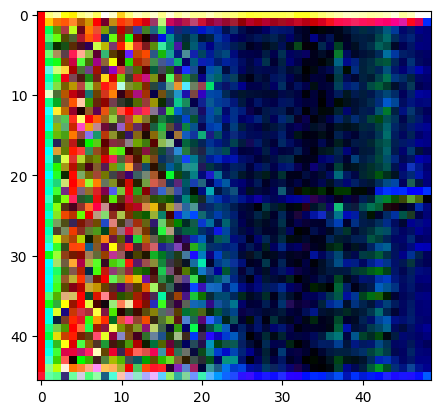

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 23, 24])


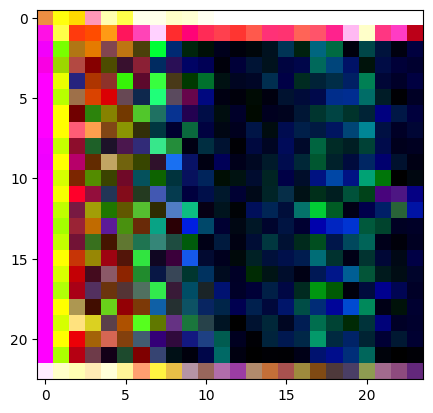

In [82]:
for i in range(5):
    classic_out = ClassicConv(tensor_image)
    print(classic_out.shape)
    image_out = classic_out.squeeze(0).detach().numpy()
    plt.imshow(image_out.transpose(1, 2, 0))
    plt.show()

    tensor_image = classic_out

In [85]:
to_tensor = transforms.ToTensor()

# Apply the transformation to convert the image to a PyTorch tensor

image = Image.open("./data/custom/spectrogram.png").convert("RGB")
tensor_image = to_tensor(image)

tensor_image = tensor_image.unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 370, 395])


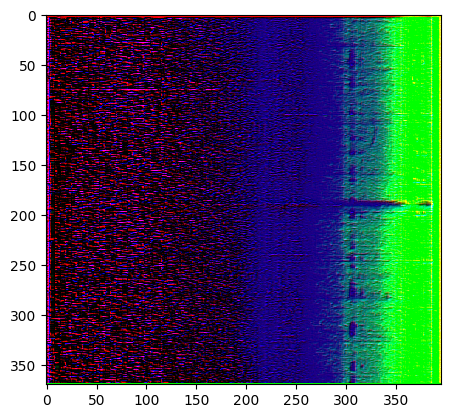

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 185, 197])


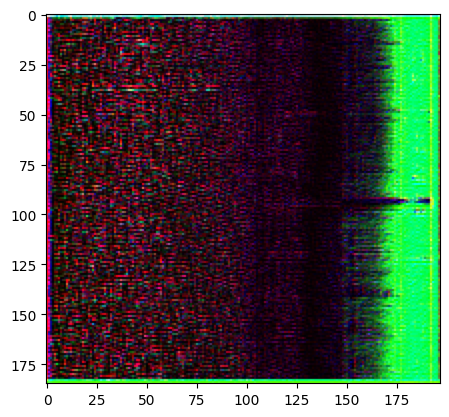

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 92, 98])


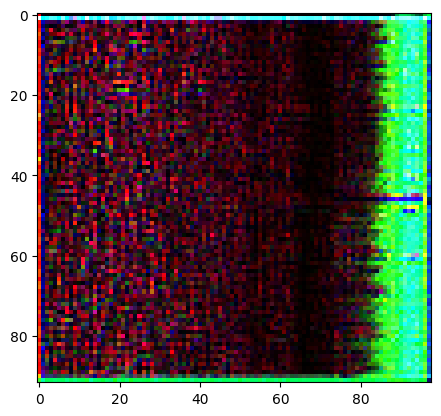

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 46, 49])


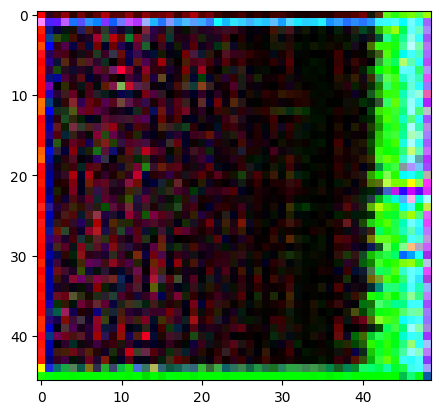

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 23, 24])


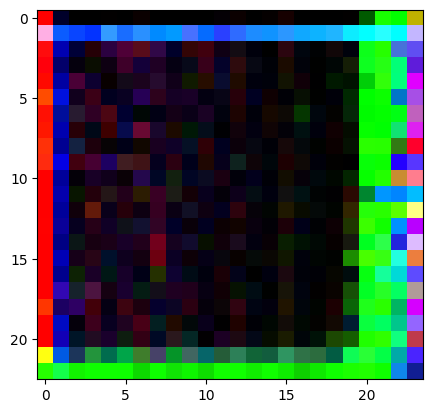

In [86]:
for i in range(5):
    sep_out = SeparableConv(tensor_image)
    print(sep_out.shape)
    image_out = sep_out.squeeze(0).detach().numpy()
    plt.imshow(image_out.transpose(1, 2, 0))
    plt.show()

    tensor_image = sep_out